*Do not delete this style setting*

In [1]:
%%html
<style>
table {float:left}
</style>

# Session 3<br> A Simple Quantum Classifier

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To explore the creation and use of a simple quantum classifier in <strong>PennyLane</strong> and <strong>PyTorch</strong>.<br>
            Compare the quantum classifier with the equivalent classical classifier.<br>
            Note that "simplicity" is only in data and the model structure - not in the approach!</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the following two datasets from UCI repository (require: pip install ucimlrepo):<br>
        <ol>
            <li><a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
              This is a database of automobile specs. The aim is to determine its insurance risk (symboling). Data loading and preprocessing was included below.</li>
            <li><a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
              The aim is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).</li>
        </ol></td></tr>
    <tr><td><strong>Tasks:</strong></td>
        <td>40 minutes (unfinished tasks go to self-directed "challenges")</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at end of this notebook):<br>
        <ol>
            <li>Initially use the <strong><em>Automobiles</em></strong> dataset 1 (as provided).<br>
                Follow the instructor demonstration to step through the code.<br>
                - we will first look at a classical PyTorch model<br>
                - and then look at the quantum PyTorch+PennyLane model.</li>
            <li>Explore your dataset and think of its impact on the process and results:<br>
                - hint: consider data ordering and what needs to be done about it</li>
            <li>Can you improve the model performance by changing the approach<br>to dimensionality reduction:<br>
                - feature selection based on intuition (default) ?<br>
                - feature selection based on Chi2 ?<br>
                - dimensionality reduction based on PCA ?<br>
                Which of these approaches had the greatest impact on performance?</li>
            <li>Improve the model performance.<br>
                - changes may apply to data, model and its training<br>
                - what methods have you applied and with what result ?</li>
            <li>Create some data on the fantasy automobiles and use the developed model for<br>
                their classification. Does it match your expectation?</li>
            <li>Compare the classical vs quantum classification models and their performance.</li>
            <li>Reflect on this session.</li>
        </ol></td>
    </tr>
    <tr>
        <td><strong>Challenge<br>Tasks:</strong></td>
        <td>Perform one or more of the following tasks in your own time:<br/>
        <ol style="list-style-type: upper-alpha;">
            <li>Complete the unfinished tasks.</li>
            <li>Incorporate custom initialisation of your model (research).</li>
            <li>Change the quantum model by incorporating a full-reuploading ansatz.</li>
            <li>Add an ROC curve analysis for the best model result (research).</li>
            <li>Include the quantum model definition as part of the <strong><em>Quantum_Auto</em></strong> class.</li>
            <li>Change (back) the label variable from binary to multiclass (hard), <br>
                to implement and test a multinomial classification model (research).</li>
            <li>Create a confusion matrix, with sensitivity and specificity for each class (research).</li>
            <li>Apply your completed model to the <strong><em>Sonar</em></strong> data set 2</li>
        </ol></td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><ul>
            <li><a href = "https://www.youtube.com/watch?v=OIenNRt2bjg" target="_blank">
                AssemblyAI, “PyTorch Crash Course - Getting Started with Deep Learning”,<br>YouTube Video, Jul 2022.</a></li>
            <li><a href = "https://pennylane.ai/qml/demos/tutorial_qnn_module_torch" target="_blank">Thomas Bromley, "Turning quantum nodes into Torch Layers",<br>
                PennyLane Demo, October 7, 2024.</a></li>
            <li><a href = "https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html" target="_blank">PennyLane, "qml.qnn.TorchLayer",<br>
                PennyLane Documentation, Code API, 2025.</a></li>
            <li><a href = "https://pennylane.ai/qml/demos/tutorial_local_cost_functions" target="_blank">Thomas Storwick, "Alleviating barren plateaus with local cost functions",<br>
                PennyLane Tutorial, November 6, 2024.</a></li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the <a href="https://www.gnu.org/licenses/gpl-3.0.txt" target="_blank">GPL-3.0</a> license</td></tr>
</table>

## Libraries

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
### General libraries

import os
import pylab
import math
import time
import copy
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
### Import utilities
from utilities import multi_plot_hist, multi_plot_series, draw_circuit

In [5]:
### Import PennyLane and Torch
import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

---

## <font color="blue">Data preparation</font>
<font color="LightCoral">Task 1: Follow the instructor demonstration to step through the code.</font>
- <font color="LightCoral">we will first look at the classical model</font>
- <font color="LightCoral">and then look at the quantum model.</font>

Selected dataset: <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>.
  
<font color="CornflowerBlue">_**Data needs to be prepared as follows:**_</font>

- <font color="CornflowerBlue">*Load and understand data*</font>
- <font color="CornflowerBlue">*Select numerical variables only (make it simple)*</font>
- <font color="CornflowerBlue">*Eliminate missing values*</font>
- <font color="CornflowerBlue">*Prepare the label (change it to binary)*</font>
- <font color="CornflowerBlue">*Standardise predictors*</font>
- <font color="CornflowerBlue">*Reduce dimensionality*</font>

<font color="CornflowerBlue">Note that for brevity of this demonstration we will apply data processing to the entire dataset rather than the training and test sets separately.</font>

In [6]:
### Dataset settings
#   Decide how many data features to be modelled (will be transformed)
n_features = 5
data_seed = 42

### Load and understand data

In [7]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)
X_vars = auto.data.features 
y_class = auto.data.targets 
print(auto.metadata['additional_info']['summary'],'\n') 

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute. 



In [8]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


<br>
<font color="LightCoral">Task 2: Investigate data preparation and its impact on the process and results.</font><br>

- <font color="LightCoral">Hint: consider data ordering and what needs to be done about it</font>

### Preliminary data processing

In [9]:
### After a brief investigation, it is evident that ...
#   this data set has a serious problem and cannot be used as it is!
...

Ellipsis

### Select numerical predictors only

In [10]:
### Select numeric columns only
X_sel = X_vars.select_dtypes(include=np.number)
X_sel.columns

Index(['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower',
       'compression-ratio', 'stroke', 'bore', 'engine-size',
       'num-of-cylinders', 'curb-weight', 'height', 'width', 'length',
       'wheel-base', 'num-of-doors', 'normalized-losses'],
      dtype='object')

### Deal with missing values

In [11]:
### Identify columns with missing values
X_sel.isna().sum().loc[lambda x : x > 0].sort_index()

bore                  4
horsepower            2
normalized-losses    41
num-of-doors          2
peak-rpm              2
price                 4
stroke                4
dtype: int64

In [12]:
### Replace missing values with column mean
#   Then check that missing values have been eliminated
auto_xmean = X_sel.mean()
X_sel = X_sel.fillna(auto_xmean)
X_sel.isna().sum().loc[lambda x : x > 0]

Series([], dtype: int64)

### Standardise predictors

In [13]:
# Standardise all variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler
auto_scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled = auto_scaler.fit_transform(X_sel) 
X_std = pd.DataFrame(scaled, columns=X_sel.columns)
# multi_plot_hist(X_std, n_cols = 5, figsize=(8,5.5));

### Prepare the label
<font color="CornflowerBlue">As the label is numeric and multi-class, to simplify the task we turn the label into a binary variable.<br>
The binary class split will be around the distribution mean.</font>

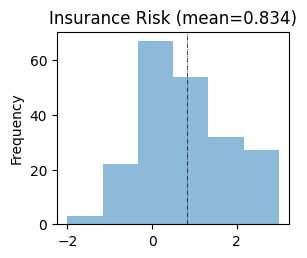

In [14]:
### Observe label distribution
auto_ymean = y_class["symboling"].mean()
ax = y_class.plot.hist(bins=6, alpha=0.5, title=f'Insurance Risk (mean={round(auto_ymean, 3)})', 
                       figsize=(3,2.5))
ax.get_legend().remove()
plt.axvline(auto_ymean, color='k', linestyle='-.', linewidth=0.5);

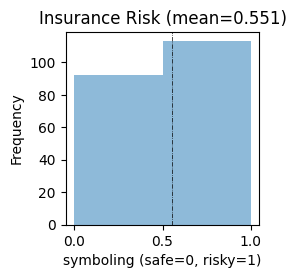

In [15]:
### Create a binary label
pd.set_option('display.max_rows', 10)
y_std = pd.DataFrame(y_class)
y_std['symboling'] = np.where(y_std['symboling'] > auto_ymean, 1, 0)
y_binmean = y_std["symboling"].mean()

ax = y_std.plot.hist(bins=2, alpha=0.5, title=f'Insurance Risk (mean={np.round(y_binmean, 3)})', 
                 figsize=(2.5,2.5))
ax.set_xlabel(f'{y_std.columns[0]} (safe=0, risky=1)')
ax.get_legend().remove()
plt.axvline(y_binmean, color='k', linestyle='-.', linewidth=0.5);

### Reduce data dimensionality

<font color="LightCoral">Task 3: Change the approach to dimensionality reduction.</font><br>
- <font color="LightCoral">Experiment with the following three approaches: based on the hunch, Chi2 feature selection and PCA</font>
- <font color="LightCoral">Which of these approaches had the greatest impact on performance?</font>

<font color="CornflowerBlue">Each method prepares a different version of the dataset: X_hunch, X_kbest, X_pca - assign it to X.</font>

In [16]:
### The number of features to select
col_names = list(X_std.columns)
print(f'\nNumber of features available: {X_std.shape[1]}\n'+\
      f'Number of features to select: {n_features}\n\n'+\
      f'Features: {*col_names,}')


Number of features available: 17
Number of features to select: 5

Features: ('price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower', 'compression-ratio', 'stroke', 'bore', 'engine-size', 'num-of-cylinders', 'curb-weight', 'height', 'width', 'length', 'wheel-base', 'num-of-doors', 'normalized-losses')


#### Feature selection based on intuition

In [17]:
X_hunch = X_std[['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower']]
X_hunch.columns

Index(['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower'], dtype='object')

#### Feature selection based on statistical analysis (ANOVA F-test or $\chi^2$)

In [18]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Feature extraction
selector = SelectKBest(score_func=f_classif, k=n_features)
X_ext = selector.fit_transform(X_std, y_std)

# Identify selected features
columns_mask = selector.get_support()
sel_features = X_std.columns[columns_mask]
X_kbest = pd.DataFrame(data = X_ext, columns = sel_features)
X_kbest.columns

Index(['curb-weight', 'height', 'length', 'wheel-base', 'num-of-doors'], dtype='object')

#### Dimensionality reduction with PCA

In [19]:
from sklearn.decomposition import PCA

n_components = n_features
auto_pca = PCA(n_components=n_components)
X_pca = auto_pca.fit_transform(X_std)
X_pca = pd.DataFrame(X_pca, columns=[f'PC{n:02d}' for n in range(X_pca.shape[1])])
pca_var = auto_pca.explained_variance_ratio_
print(f'Explained var = {np.sum(pca_var):02.3f}')
X_pca.columns

Explained var = 0.869


Index(['PC00', 'PC01', 'PC02', 'PC03', 'PC04'], dtype='object')

#### Select an approach to dimensionality reduction
<font color="CornflowerBlue">Select the method of dimensionality reduction by copying the required version of X.<br>
All versions have been defined above.</font>

In [20]:
X = X_hunch.copy()
y = y_std.copy()

***

## <font color="blue">Model development</font>

<font color="LightCoral">Task 4: Improve the model performance.</font><br>
- <font color="LightCoral">Apply changes to data, the model and its training.</font>
- <font color="LightCoral">What methods have you applied and with what result ?</font>

### Utilities

<font color="CornflowerBlue">Note that for the model training purposes, <strong><em>mse_cost</em></strong> defined here cannot be replaced by sklearn <strong><em>mean_squared_error</em></strong>,<br>
as it does not understand gradients. When using PyTorch, we will use its full suite of gradient-aware loss/cost functions.</font><br>
<font color="blue">Beware that PennyLane and PyTorch loss functions take params in different order, params order in PyTorch is very important!</font>

In [21]:
### Performance measures

### A simple MSE cost function
def square_mse(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

### Calculates accuracy from expval predictions
def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()

### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on
<font color="CornflowerBlue">Note that this workshop notebooks have not been optimised 
for working with GPUs. So, it is best to "force" the CPU based computation or else 
GPU will tremendously slow down your code execution!</font>

In [22]:
### Find what devices are available

# Quantum simulator
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable GPU device if available
if torch.cuda.is_available():   # for Linux / Windows with GPU
    torch_device = 'cuda'
elif torch.mps.is_available():  # for Mac with GPU
    torch_device = 'mps'
else:
    torch_device = 'cpu'        # for everybody else
    
print(f'\nThe available devices:\t{sim} and {torch_device}')

# If you want to force CPU if working with GPU is slow (our unoptimised code)
torch_device = "cpu"

print(f'Devices to be used:\t{sim} and {torch_device}\n')


The available devices:	lightning.qubit and cuda
Devices to be used:	lightning.qubit and cpu



### Model and training configuration

In [23]:
### Data params
n_data = X.shape[0]
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max = np.pi-x_angle_margin

### Architectural params
n_wires = X.shape[1]  # The model ansatz may have less data than wires
n_layers = 5
wires = list(range(n_wires))

### Training params
epochs = 80      # 50 # 80 # 100 # 300
log_interv = 1   # History to be saved only once every interv or epochs
acc_prec = 0.5   # Precision of accuracy calculation
shots = None     # None means using theoretical frequency distribution 
seed = 2025

### Prepare data for the quantum classifier

<font color="CornflowerBlue">Note that we have already scaled the X values to the [0..1] range.<br>
That value range was needed to perform PCA, if this dimensionality reduction was to be used.<br>
We could not scale X to the range of values [0..pi] as required for quantum data encoding,<br>
as PCA would have changed that range later on.</font>

In [24]:
### Standardise X values to the range 0+margin..pi-margin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X) 
X = pd.DataFrame(scaled, columns=X.columns)

In [25]:
### Create data partitions, data has been shuffled before
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
    test_size=0.33, shuffle=False, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(137, 5), X_test=(68, 5), y_train=(137, 1), y_test=(68, 1)


In [26]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

### PennyLane model

<font color="CornflowerBlue">Note that this model, unlike the models in Session 1, uses <strong><em>AngleEmbedding</em></strong> function to crate a data encoding block.<br>
However, if you were going to change the model to a full data reuploading ansatz, this function will not be useful.</font>


In [27]:
### Define a simple quantum model
def qmodel(n_wires):
    wires = list(range(n_wires))
    def _qmodel(inputs, weights):
        nonlocal wires, n_wires #, meas_wires
        qml.AngleEmbedding(inputs, wires=wires)        
        qml.StronglyEntanglingLayers(weights, wires=wires)
        return [qml.expval(qml.PauliZ(0))]
    return _qmodel

In [28]:
### Check the model shape
def qshape(n_wires, n_layers=1):
    shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

### PyTorch model with PennyLane layer

<font color="CornflowerBlue">To use PennyLane Torch layers refer to the 
<a href="https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html" target="_blank">TorchLayer PennyLane API</a>
as well as <a href = "https://pennylane.ai/qml/demos/tutorial_qnn_module_torch" target="_blank">Thomas Bromley tute on Torch layers</a>.</font>

In [29]:
### Create a PyTorch model with a PennyLane circuit within

class Quantum_Auto(nn.Module):

    def __init__(self, sim, n_wires, n_layers=1, shots=None):
        super(Quantum_Auto, self).__init__()

        self.sim = sim
        self.n_wires = n_wires
        self.n_layers = n_layers
        self.shots = shots

        # Wrap a torch layer around the PennyLane model
        layers = [self.layers()]
        self.model_pt = nn.Sequential(*layers)  

    ### Define a quantum layer
    def layers(self):
        
        # Specify a device
        dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)

        # Define the quantum model and its circuit (or node, save it for later)
        model_pl = qmodel(self.n_wires)
        self.model_qc = qml.QNode(model_pl, dev, interface='torch')

        # Define the shape of the model weight parameters
        # Note that the name "weights" must match the param name defined in function 
        # "model_pl" which in our case is _qmodel(inputs, weights)
        weights_shapes = {"weights": qshape(self.n_wires, n_layers=self.n_layers)}

        # Turn the circuit into a Torch-compatible quantum layer
        qlayer = qml.qnn.TorchLayer(self.model_qc, weight_shapes=weights_shapes)
        return qlayer

    ### Return the quantum model circuit
    def qmodel_qc(self):
        return self.model_qc
 
    ### Apply the model to data (forward step)
    def forward(self, x):
        y = self.model_pt(x)
        return y

### Test the PennyLane/PyTorch model before use

In [30]:
### Create a test model and draw the test model circuit
test = Quantum_Auto(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots).double().to(torch_device)
shape = qshape(X_train_tens.shape[1], n_layers)
n_weights = np.prod(shape)

print(f'\nQM weights: {count_params(test)}, Epochs: {epochs}')
print(f'\nTest results: {test(X_train_tens[0:5])}\n')

### Show the structure of the torch model
test.eval()


QM weights: 75, Epochs: 80

Test results: tensor([[-0.1271],
        [-0.1045],
        [-0.0653],
        [ 0.0361],
        [ 0.0648]], dtype=torch.float64, grad_fn=<ViewBackward0>)



Quantum_Auto(
  (model_pt): Sequential(
    (0): <Quantum Torch Layer: func=_qmodel>
  )
)

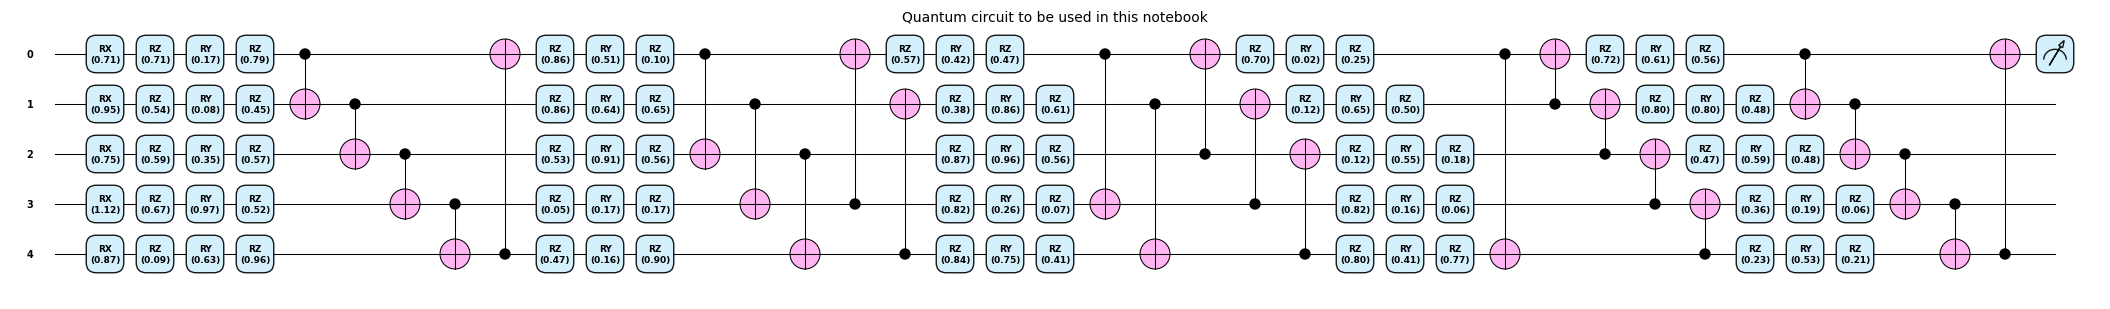

In [31]:
### Draw the test model circuit
weights = torch.rand(shape, requires_grad=True)
draw_circuit(test.qmodel_qc(), scale=0.5, title='Quantum circuit to be used in this notebook', level='device') \
    (X_train_tens[0], weights) # level='device'/'gradient'

### Creation and training of the PennyLane/PyTorch model

In [32]:
### Trains a PyTorch model (of any kind)

def train_model(model, X, y, cost_fun, acc_fun, optimizer, epochs, 
                log_interv=100, prompt_fract=0.1, acc_prec=0.5, start_time=0):
    
    history = []
    acc_hist = []
    opt_params = {}
    hist_params = []
    min_epoch = 0
    min_cost = 1000
    max_acc = -1000
    if start_time == 0: start_time = time.time()
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_cost = cost.item()
        curr_acc = acc
        if curr_cost < min_cost: 
            min_cost = curr_cost
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc > max_acc:
            max_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_cost)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        elapsed = time.time() - start_time
        if (prompt_fract == 0) or (epoch % int(prompt_fract*epochs) == 0):
            print(f'{epoch: 5d} '+ \
                  f'({elapsed:06.0f} sec): '+ \
                  f'Cost {curr_cost:6.4g}   '+ \
                  f'Acc {curr_acc:6.4g}')
            
    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)

### Training loop

In [33]:
### Ensure repeatability
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
q_auto = Quantum_Auto(sim, n_wires, 
                      n_layers=n_layers, shots=shots).double().to(torch_device)

### Loss and optimiser
# cost_fun = nn.CrossEntropyLoss()
cost_fun = nn.MSELoss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# opt = torch.optim.Adam(q_auto.parameters())
opt = torch.optim.NAdam(q_auto.parameters(), lr=0.01)

### Train the model
print()

prompt_fract = 0.1
start_time = time.time()
train_mse_hist, train_acc_hist, opt_params, hist_params, opt_point = \
    train_model(q_auto, X_train_tens, y_train_tens, cost_fun, accuracy, opt, epochs, 
                log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)
elapsed = time.time() - start_time

### Print the training summary
train_min_mse = np.min(train_mse_hist)
train_min_mse_iter = np.argmin(train_mse_hist)
train_max_acc = np.max(train_acc_hist)
train_max_acc_iter = np.argmax(train_acc_hist)

time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
print(f'\nTraining completed: epochs={epochs} '+\
      f'in {elapsed:0.0f}sec ({time_str})\n\t'+
      f'min MSE = {np.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'max ACC = {np.round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}')


    0 (000001 sec): Cost 0.5951   Acc 0.3796
    8 (000005 sec): Cost 0.3279   Acc 0.3796
   16 (000010 sec): Cost 0.2493   Acc 0.6204
   24 (000015 sec): Cost 0.2254   Acc 0.6642
   32 (000020 sec): Cost 0.2139   Acc 0.6934
   40 (000025 sec): Cost 0.2068   Acc  0.708
   48 (000029 sec): Cost 0.2017   Acc 0.7153
   56 (000034 sec): Cost 0.1982   Acc 0.7445
   64 (000039 sec): Cost 0.1956   Acc 0.7445
   72 (000044 sec): Cost 0.1937   Acc 0.7518

Training completed: epochs=80 in 48sec (00:00:47)
	min MSE = 0.1923 @ 0079, max ACC = 0.7591 @ 0078


### Calculate testing scores

In [34]:
### Accumulate test scores
test_mse_hist = []
test_acc_hist = []

### Initialise testing loss and accuracy
test_min_mse = 1000
test_min_mse_iter = -1
test_max_acc = 0
test_max_acc_iter = -1

### Calculate testing loss and accuracy
for iter in range(len(hist_params)):
    q_auto.load_state_dict(hist_params[iter])
    test_pred = q_auto(X_test_tens)
    curr_acc = accuracy(y_test_tens, test_pred, prec=acc_prec)
    curr_cost = square_mse(y_test_tens, test_pred)
    test_acc_hist.append(curr_acc)
    test_mse_hist.append(curr_cost)
    if curr_acc > test_max_acc:
        test_max_acc = curr_acc
        test_max_acc_iter = iter
    if curr_cost < test_min_mse:
        test_min_mse = curr_cost
        test_min_mse_iter = iter

### Run summary
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
print(f'\nCompleted calculation of testing scores\n\nSummary of model training run\n\n\t'+
      f'params = {count_params(q_auto)}, '+
      f'epochs = {epochs}, '+
      f'time = {elapsed:0.0f}sec ({time_str})\n\t'+
      f'training: MSE = {np.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'ACC = {np.round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}\n\t'+
      f'testing:  MSE = {np.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'ACC = {np.round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}'+
      f'\n'
     )


Completed calculation of testing scores

Summary of model training run

	params = 75, epochs = 80, time = 48sec (00:00:47)
	training: MSE = 0.1923 @ 0079, ACC = 0.7591 @ 0078
	testing:  MSE = 0.2461 @ 0012, ACC = 0.5882 @ 0000



### Plot costs and scores

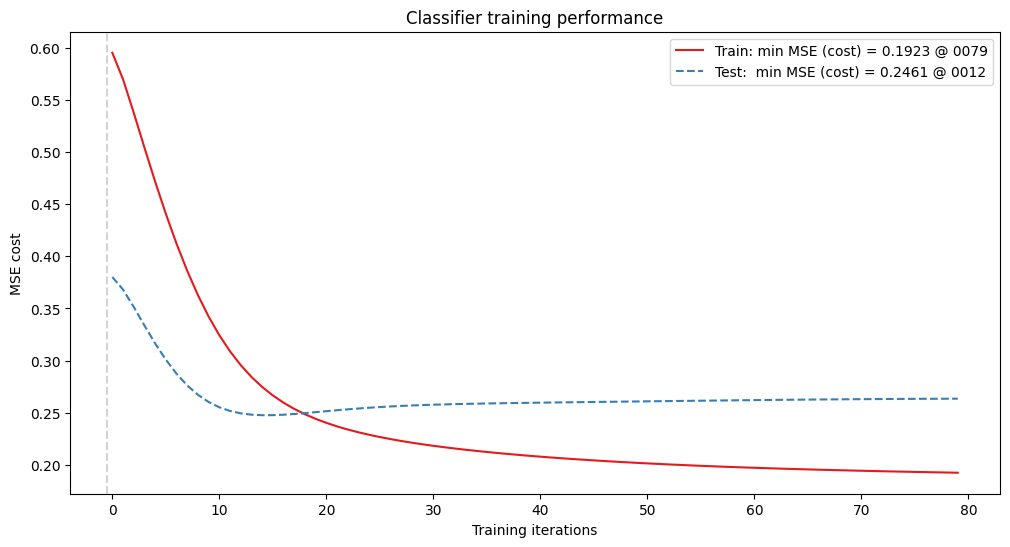

In [35]:
train_label = f'Train: min MSE (cost) = {round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}'
test_label =  f'Test:  min MSE (cost) = {round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}'
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='MSE cost',
    legend_cols=1, smooth_weight=0.6, title='Classifier training performance')

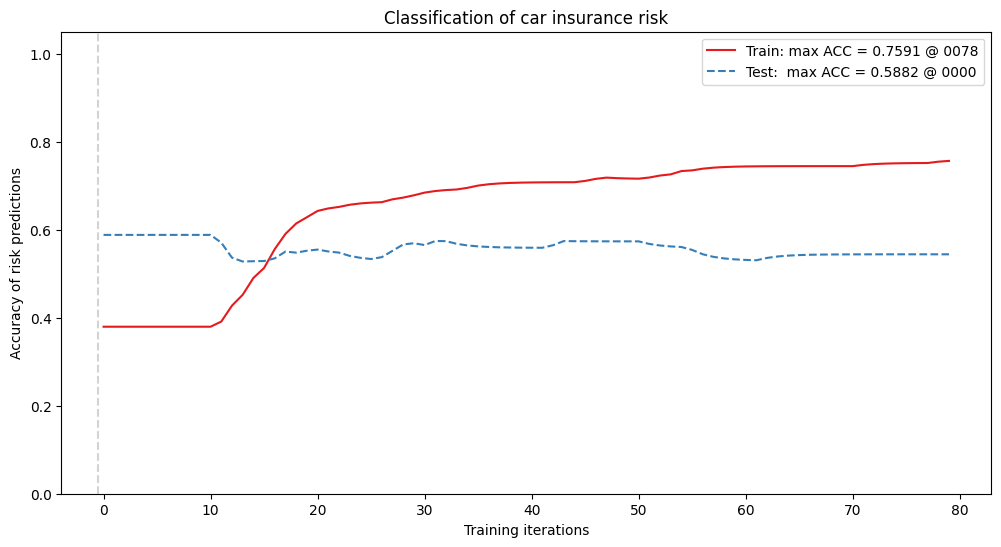

In [36]:
train_label = f'Train: max ACC = {round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}'
test_label =  f'Test:  max ACC = {round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}'
multi_plot_series(
    [train_acc_hist, test_acc_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'dashed'], ylim=(0, 1.05), # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='Accuracy of risk predictions',
    legend_cols=1, smooth_weight=0.6, title='Classification of car insurance risk')

---

## Write your observations here

- Task 1:
- Task 2:
- Task 3:
- Task 4:
- Task 5:
- Challenge:
- Reflection:

## Software (Linux)

In [37]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
torch                     2.6.0
torchaudio                2.6.0
torcheval                 0.0.7
torchmetrics              1.6.1
torchsummary              1.5.1
torchvision               0.21.0
